In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [48]:
df = pd.read_csv("datasets/heart.csv")

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Атрибуты
* **age** - возраст
* **sex** - пол (1 - мужчина, 0 - женщина)
* **cp** - диагноз (0 - типичная стенокардия, 1 - атипичная стенокардия, 2 - боль не характерная стенокардии, 3 - симптоматика нескольких диагнозов)
* **trestbps** - *resting blood pressure* - артериальное давление в состоянии покоя при поступлении в стационар (мм. рт. столба)
* **chol** - холестерол (мг/дл)
* **fbs** - *fasting blood sugar* - уровень сахара в крови натощак >120 мг/дл
* **restecg** - результаты ЭКГ в состоянии покоя (0 - в пределах нормы, 1 - присутствие ST-T-аномалий, 2 - гипертрофия левого желудочка по кр. Эстеса)
* **thalach** - достигнутая максимальная частота сердечных сокращений
* **exang** - стенокардия под физической нагрузкой (1 - присутствует; 0 - нет)
* **oldpeak** - депрессия сегмента ST, вызванная физической нагрузкой относительно покоя
* **slope** - наклон пика в ST сегменте при физической нагрузке
* **ca** - количество крупных сосудов (0-3), окрашенных флуороскопией
* **thal** - талассемия (1 - легкая; 2 - средняя; 3 - тяжелая форма)
* **target** - подтверждение заболевания (1 - нет, 0 - да)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Как видим, данные без пропусков, число столбцов и строк равно 14 и 303 соответственно. Оценим целевой параметр:

In [5]:
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

Разница числа пациентов выборки небольшая. Рассмотрим распределение пациентов относительно вида боли при поступлении в стационар

In [6]:
df["cp"].value_counts(normalize=True)

0    0.471947
2    0.287129
1    0.165017
3    0.075908
Name: cp, dtype: float64

Преимущественно (порядка 47% от объема выборки) пациенты поступали с симптомами типичной стенокардии. Сравним средние показатели больных и здоровых пациентов.

In [7]:
df[df["target"] == 1].mean()

age          52.496970
sex           0.563636
cp            1.375758
trestbps    129.303030
chol        242.230303
fbs           0.139394
restecg       0.593939
thalach     158.466667
exang         0.139394
oldpeak       0.583030
slope         1.593939
ca            0.363636
thal          2.121212
target        1.000000
dtype: float64

In [8]:
df[df["target"] == 0].mean()

age          56.601449
sex           0.826087
cp            0.478261
trestbps    134.398551
chol        251.086957
fbs           0.159420
restecg       0.449275
thalach     139.101449
exang         0.550725
oldpeak       1.585507
slope         1.166667
ca            1.166667
thal          2.543478
target        0.000000
dtype: float64

Выведем основные статистические характеристики данных для понимания разницы сравниваемых величин

In [9]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Такие показатели как результаты ЭКГ, максимальная ЧСС и наклон в ST сегменте оказались в среднем выше у здоровых людей .Так же эти пациенты реже имели признаки типичной стенокардии.

Обратное можно отметить касательно таких показателей как АД, стенокардия под физической нагрузкой, депрессия ST-сегмента, кол-во крупных окрашенных сосудов, талассемия. Так же стоит отметить, что у женщин реже подтверждался поставленный диагноз, а средний возраст людей с неподтвержденным диагнозом оказался выше.

Средние показатели остальных параметров (уровень холестерола, уровень сахара в крови) оказались приблизительно равны.

Попробуем проанализировать как подтверждение заболевания связано с возникновением стенокардии под физической нагрузкой

In [10]:
pd.crosstab(df["target"], df["exang"], margins=True)

exang,0,1,All
target,,,
0,62,76,138
1,142,23,165
All,204,99,303


<AxesSubplot:xlabel='exang', ylabel='count'>

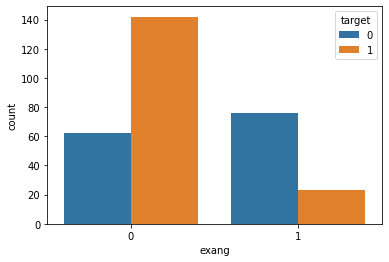

In [11]:
sns.countplot(x='exang', hue='target', data=df)

Как видим, большая доля пациентов с не подтвердившимся заболеванием оказались не подвержены стенокардии под физической нагрузкой (что вполне логично), касательно больных же сложно выявить похожую зависимость.

<AxesSubplot:xlabel='slope', ylabel='count'>

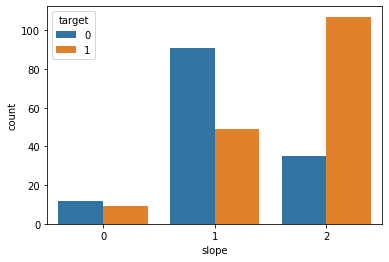

In [12]:
sns.countplot(x='slope', hue='target', data=df)

У большинства больных(~60-70%) наблюдается наклон пика в ST-сегменте равный 1, в то время как у здоровых пациентов - 2.

<AxesSubplot:xlabel='ca', ylabel='count'>

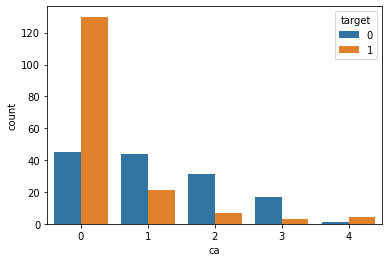

In [13]:
sns.countplot(x='ca', hue='target', data=df)

Почти у всех здоровых людей крупные сосуды не окрашены флуороскопией

In [14]:
results = pd.crosstab((df["ca"]==0).astype(int) & 
            (df["slope"]>0).astype(int) & 
            (df["exang"]==0).astype(int), df["target"])

In [15]:
def get_accuracy(TP, FP, TN, FN):
    return (TP + TN)/(TP + TN + FP + FN)

def get_precision(TP, FP):
    return TP/(TP + FP)

def get_recall(TP, FN):
    return TP / (TP + FN)

In [16]:
print(f'Accuracy: {round(get_accuracy(results[1][1], results[0][1], results[0][0], results[1][0]), 2)}')
print(f'Precision: {round(get_precision(results[1][1], results[0][1]), 2)}')
print(f'Recall: {round(get_precision(results[1][1], results[1][0]), 2)}')

Accuracy: 0.74
Precision: 0.85
Recall: 0.64


Итак, нам удалось достигнуть accuracy, равной 74.3% на основании приведенных сверху трех рассуждениях. С учетом приблизительно равного числа больных и здоровых пациентов, это неплохой показатель для данного этапа. Высокий показатель precision свидетельствует о том, что большая доля определенных пациентов как здоровых действительно оказались здоровыми, в то время как наиболее низкий recall говорит о том, что определены далеко не все здоровые(лишь 64%) пациенты.

Отобразим корреляцию атрибутов и приступим к использованию алгоритмов МО.

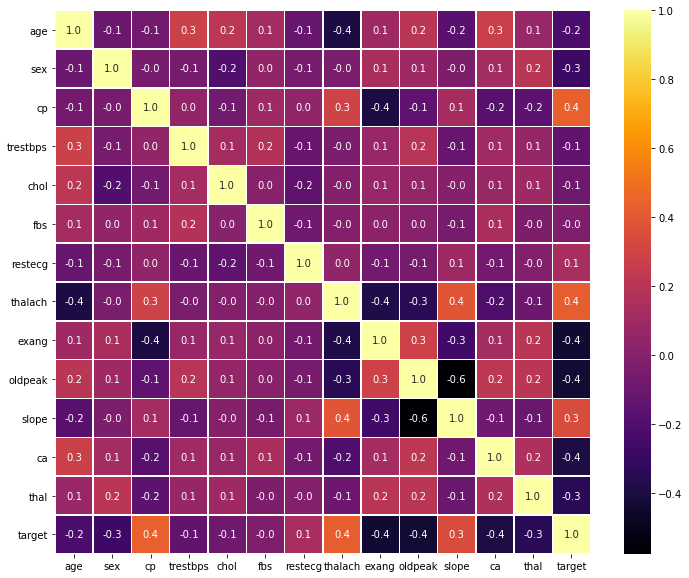

In [17]:
f,ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="inferno", linewidths=.5, fmt= '.1f',ax=ax);

In [49]:
Y = df.pop('target')
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.2)

## Метод kNN

              precision    recall  f1-score   support

           0       0.64      0.62      0.63        26
           1       0.72      0.74      0.73        35

    accuracy                           0.69        61
   macro avg       0.68      0.68      0.68        61
weighted avg       0.69      0.69      0.69        61

0.6791208791208792


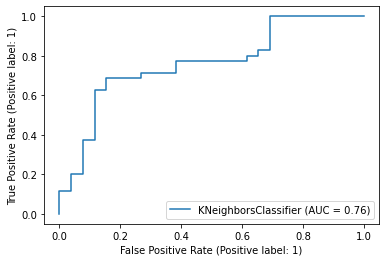

In [76]:
knn_model = KNeighborsClassifier(n_neighbors=25, weights='distance', metric='euclidean')
knn_model.fit(X_train, Y_train)
knn_prediction = knn_model.predict(X_test)
print(classification_report(Y_test, knn_prediction))
# print(roc_auc_score(Y_test, knn_prediction))
plot_roc_curve(knn_model, X_test, Y_test)
plt.show()

## Линейный классификатор

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.89      0.89      0.89        35

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

0.8659340659340659


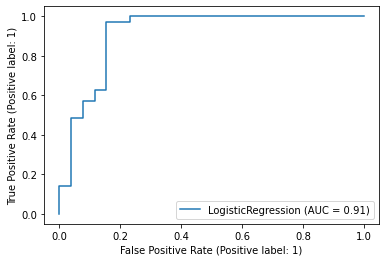

In [77]:
log_model = LogisticRegression()
log_model.fit(X_train,Y_train)
log_prediction = log_model.predict(X_test)
print(classification_report(log_prediction, Y_test))
# print(roc_auc_score(Y_test, log_prediction))
plot_roc_curve(log_model, X_test, Y_test)
plt.show()

## Метод опорных векторов

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

0.8373626373626374


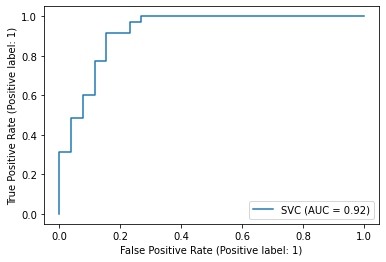

In [78]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, Y_train)
svm_prediction = svm_model.predict(X_test)
print(classification_report(svm_prediction, Y_test))
# print(roc_auc_score(Y_test, svm_prediction))
plot_roc_curve(svm_model, X_test, Y_test)
plt.show()

## Байесовский классификатор

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.83      0.85      0.84        34

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

0.8181318681318682


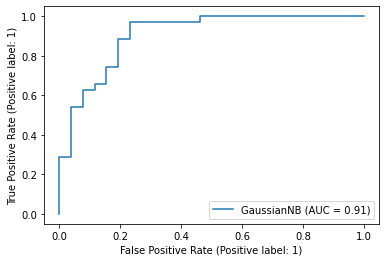

In [79]:
bayes_model = GaussianNB()
bayes_model.fit(X_train, Y_train)
bayes_prediction = bayes_model.predict(X_test)
print(classification_report(bayes_prediction, Y_test))
# print(roc_auc_score(Y_test, bayes_prediction))
plot_roc_curve(bayes_model, X_test, Y_test)
plt.show()